In [1]:
# Installing necessary particle physics libraries
!pip install energyflow
!pip install h5py
!pip install POT

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Installing my library: make sure version 1.0.9 is installed for calculating default AUC values
!pip install --user particledist==1.0.9

**The following code calculates default AUC values between mass bins without any signal injection**

In [3]:
# Standard library imports
from __future__ import absolute_import, division, print_function
from time import process_time
import energyflow as ef
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Load data
specs = ['375 <= corr_jet_pts <= 425', 'abs_jet_eta < 1.9', 'quality >= 2']
amount = 0.2
sim = ef.mod.load(*specs, dataset='sim', amount=amount)
print("Number of jets: ", len(sim))

print("Max: ", np.amax(sim.jet_ms))
print("Min: ", np.amin(sim.jet_ms))

Number of jets:  504909
Max:  143.2047119
Min:  3.663904428


In [5]:
# Import my library
from particledist import ParticleDistributionCMS

Constructs a ParticleDistributionCMS object; accepts 1 parameter: the EnergyFlow data object generated by `ef.mod.load()`. The constructor automatically pulls the relevant information from the EnergyFlow simulation data format and stores it in instance variables for easy access. This process takes a while (usually ~ 1 hour).

The instance variables that are initialized in the constructor are the following:

`self.event_list`: Stores all data on the particles in each jet, grouped by event. Each particle is represented as a 4-vector - (pt,y,phi,pid), where pid is the particle's PDG ID. The jet arrays are not padded.

`self.event_jet_labels`: Stores the particle IDs of the hard partons associated to each jet, grouped by event. In this dataset, all partons are either quarks or gluons.

`self.event_pts`: Stores transverse momentum of the jets, grouped by event.

`self.event_etas`: Stores pseudorapidities of the jets, grouped by event.

`self.event_phis`: Stores azimuthal angles of the jets, grouped by event.

`self.event_ms`: Stores masses of the jets, grouped by event.

`self.event_stats`: Stores energy-momentum 4-vectors of the jets, grouped by event. These energy-momentum vectors were calculated using the pts, etas, phis, and ms from the 4 instance variables above.

All of the above variables are lists, not numpy arrays.

In [6]:
CMS_20p_dist = ParticleDistributionCMS.ParticleDistributionCMS(sim)

Elapsed time during the whole program in seconds: 3955.9736442660005


Users can choose to work with events that have 1, 2, 3, or 4 jets in them. Each variety has its own set of methods and instance variables. User can access these instance variables at any time if they want to, for example, use data from both 2-jet and 3-jet events. However, all of the following pre-processing has to be done separately for 1, 2, 3, or 4-jet events. I do the pre-processing below for just 2-jet events.

Establishes 3 instance variables to contain data for 2-jet events:

`self.event_list_2`: Stores all data on the particle 4-vectors (pt,y,phi,pid) in each jet, grouped by event. Very similar to `self.event_list`, except with only 2-jet events.

`self.event_stats_2`: Stores energy-momentum 4-vectors of the jets, grouped by event. Very similar to `self.event_stats`, except with only 2-jet events.

`self.event_jet_labels_2`: Stores the particle IDs of the hard partons associated to each jet, grouped by event. Very similar to `self.event_jet_labels`, except with only 2-jet events.

In [7]:
CMS_20p_dist.choose_2jet_events()

Up until now, the energy-momentum 4-vectors of each of the jets had been stored individually. Now, we add the 4-vectors of the jets in each event and store the results in an instance variable called `self.event_stats_added_2`.

In [8]:
CMS_20p_dist.add_event4vectors_2jet()

We have the total energy-momentum 4-vectors corresponding to each event. Now, we calculate an invariant mass for each event from these 4-vectors and store it in an instance variable called `self.event_mass_2jet`.

In [9]:
CMS_20p_dist.event_mass_2jet()

Quick check to make sure our masses were calculated properly: we show a histogram of the event masses; they look the same as when we did the same calculation manually, meaning the library likely did it correctly.

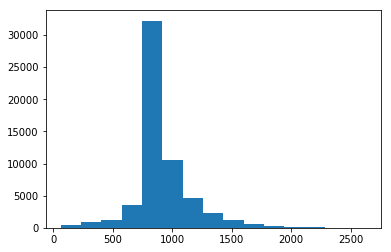

In [10]:
plt.hist(CMS_20p_dist.event_mass_2jet, bins = 15)
plt.show()

Now that we have our mass statistics, we need to divide our events into bins to form an event mass distribution. particledist uses another class for this called MassDistribution.

In [11]:
from particledist import MassDistribution

Forms a MassDistribution object. The constructor takes a list of event masses and another list of jet particle 4-vectors (like we had stored in `self.event_list`). For this analysis, I chose to use only 2-jet events, and the instance variables I pass into the constructor reflect this.

2 instances variables are created:

`self.mass_list`: Mass of the events - initialized directly from mass list that was passed in

`self.event_list`: Jet particle 4-vectors - initialized directly from event list that was passed in

In [12]:
CMS_20p_mass_dist_2jet = MassDistribution.MassDistribution(CMS_20p_dist.event_mass_2jet, CMS_20p_dist.event_list_2)

This function divides the events into different bins according to their mass. It accepts two parameters: the size of the mass bins, and the mimimum cutoff for the number of events that need to be in each mass bin.

2 instance variables are created:

`self.mass_ranges`: Ranges of mass for the bins that make the event cutoff

`self.event_mass_bins`: Jet particle 4-vectors for each bin that makes the event cutoff

In [13]:
CMS_20p_mass_dist_2jet.divide_mass_bins(100, 3000)

Show mass ranges that made the event cutoff.

In [14]:
CMS_20p_mass_dist_2jet.get_mass_ranges()

[[664.6749684373561, 764.6749684373561],
 [764.6749684373561, 864.6749684373561],
 [864.6749684373561, 964.6749684373561],
 [964.6749684373561, 1064.6749684373563],
 [1064.6749684373563, 1164.6749684373563]]

Get the number of events in each bin.

In [15]:
bins = CMS_20p_mass_dist_2jet.event_mass_bins
for bin in bins:
    print(len(bin))

5836
23041
9844
5608
3540


Extracts the jets from each event and groups them by mass bin (instead of by event). 1 new instance variable is created:

`self.jet_mass_bins`: Jet particle 4-vectors, grouped by event mass bin.

In [16]:
CMS_20p_mass_dist_2jet.extract_jets_into_mass_bins()

Cycles through each jet mass bin and pads the jet arrays so the PFN classifier will accept them. Accepts 1 parameter: the number of particles that each jet should have after padding. This number needs to be >= the largest number of particles a jet has in the dataset.

1 new instance variable is created:

`self.padded_jet_arrays`: Jet particle 4-vectors, padded and grouped by event mass bin.

In [17]:
CMS_20p_mass_dist_2jet.pad_jet_arrays(160)

The actual AUC calculations are done by a different class in particledist: PFNDist.

In [18]:
from particledist import PFNDist

Using TensorFlow backend.


Creates a new PFNDist object. Accepts 1 parameter: the padded arrays containing the jet particle 4-vectors, grouped by event mass bin.

1 instance variable is created:

`self.padded_jet_arrays`: Jet particle 4-vectors, padded and grouped by event mass bin. Initialized directly from input.

In [19]:
CMS_20p_PFN_dist_2jet = PFNDist.PFNDist(CMS_20p_mass_dist_2jet.padded_jet_arrays)

Generates AUC scores by cycling through bins. For example, if I had 5 bins, I would get 4 AUC scores from combining bins in the following way: bin 1 and bin 2, bin 2 and bin 3, bin 3 and bin 4, bin 4 and bin 5. AUC scores are stored in instance variable called `self.AUC_scores`.

In [23]:
CMS_20p_PFN_dist_2jet_AUC_scores = CMS_20p_PFN_dist_2jet.generate_AUCs(14296, 3000)

Loaded quark and gluon jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_64 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_64[0][0]              

View AUC scores. They all seem close to 0.5, which is what we are looking 

In [24]:
CMS_20p_PFN_dist_2jet_AUC_scores

[0.5225245669015399,
 0.5010987397996953,
 0.46578196860682736,
 0.5062779062331813]

**Signal Injection (still working on getting this part of the library working)**

In [26]:
from particledist import SignalInjectionTwoGluons

SyntaxError: invalid syntax (SignalInjectionTwoGluons.py, line 31)

In [25]:
CMS_20p_PFN_Sig_Inj = SignalInjectionTwoGluons(CMS_20p_dist.event_mass_2jet, CMS_20p_dist.event_jet_labels_2, CMS_20p_dist.event_list_2, 100)

NameError: name 'SignalInjectionTwoGluons' is not defined

In [ ]:
CMS_20p_PFN_Sig_Inj.filter_gluon_events()

In [ ]:
CMS_20p_PFN_Sig_Inj.sort_gluon_events()

In [ ]:
bin_700_800_gluon_events = CMS_20p_PFN_Sig_Inj.get_gluon_events_in_bin(arg)